In [34]:
# Import required packages

from omero.gateway import BlitzGateway, ColorHolder
from omero.model import MaskI
from omero.rtypes import (
    rdouble,
    rint,
    rstring,
)
import omero_rois
import omero
from getpass import getpass
#from cellpose import models, utils,plot,io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import skimage as sk
from skimage.measure import label, regionprops,regionprops_table
from skimage import morphology
from skimage.color import label2rgb
from skimage.segmentation import clear_border
from matplotlib.colors import Normalize
import pandas as pd
from tqdm import tqdm
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [8, 6]

In [35]:
# Login to OMERO

def connect(hostname, username, password):
    """
    Connect to an OMERO server
    :param hostname: Host name
    :param username: User
    :param password: Password
    :return: Connected BlitzGateway
    """
    conn = BlitzGateway(username, password,
                        host=hostname, port=4064, secure=True)
    conn.connect()
    conn.c.enableKeepAlive(600)
    return conn

HOST = '35.8.197.106'
conn = connect(HOST, input("Username: "),
               getpass("OMERO Password: "))
print("Connected as {}".format(conn.getUser().getName()))

Username: JonathanSakkos
OMERO Password: ········
Connected as JonathanSakkos


In [36]:
imageId = 249
image = conn.getObject("Image", imageId)
print(image.getName(), image.getDescription())

Control-02.czi 


Channel: TagYFP
Color: (0, 255, 0)
Lookup table: None
Is reverse intensity? False
Channel: DsRed
Color: (255, 0, 0)
Lookup table: None
Is reverse intensity? False
Channel: TL Brightfield
Color: (255, 255, 255)
Lookup table: None
Is reverse intensity? False


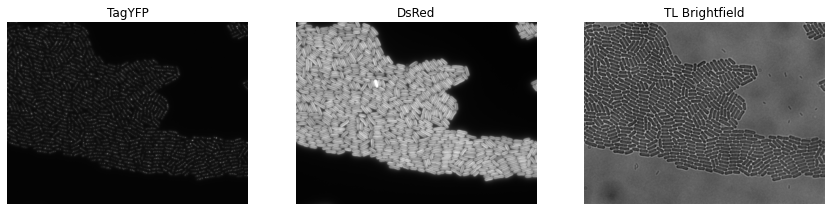

In [37]:
# View image channels separately

get_ipython().run_line_magic('matplotlib', 'inline')
pixels = image.getPrimaryPixels()
channels = image.getChannels()
plt.figure(figsize=(25, 20))
size_c = image.getSizeC()
for idx in range(0, size_c):
    plt.subplot(1, 5, idx+1)
    image_plane = pixels.getPlane(0, idx, 0)
    plt.imshow(image_plane, cmap='gray')
    plt.axis('off')
    plt.title(channels[idx].getLabel())
# List Channels (loads the Rendering settings to get channel colors)


for channel in image.getChannels():
    print('Channel:', channel.getLabel())
    print('Color:', channel.getColor().getRGB())
    print('Lookup table:', channel.getLut())
    print('Is reverse intensity?', channel.isReverseIntensity())

'TagYFP'

In [38]:
def find_chan(image,channel):
    
    """
    Finds the specified channel number from the image metadata
    """
    
    for i, chan in enumerate(image.getChannels()):
        #print(i, dic)
        if chan.getLabel() == channel:
            return i
    return -1

# Find DsRed channel for segmentation

dsred_channel = find_chan(image,'DsRed')
dsred = pixels.getPlane(0, dsred_channel, 0)


In [39]:
roi_service = conn.getRoiService()
result = roi_service.findByImage(imageId, None)
for roi in result.rois:
    print("ROI:  ID:", roi.getId().getValue())
    for s in roi.copyShapes():
        shape = {}
        shape['id'] = s.getId().getValue()
        #shape['theT'] = s.getTheT().getValue()
       # shape['theZ'] = s.getTheZ().getValue()
        if s.getTextValue():
            shape['textValue'] = s.getTextValue().getValue()
        if type(s) == omero.model.MaskI:
            shape['type'] = 'Mask'
            shape['x'] = s.getX().getValue()
            shape['y'] = s.getY().getValue()
            shape['width'] = s.getWidth().getValue()
            shape['height'] = s.getHeight().getValue()
        elif type(s) in (
                omero.model.LabelI, omero.model.PolygonI):
            print(type(s), " Not supported by this code")
        # Do some processing here, or just print:
        print("   Shape:",)
        for key, value in shape.items():
            print("  ", key, value,)
        print("")

ROI:  ID: 103
   Shape:
   id 1454
   type Mask
   x 432.0
   y 1.0
   width 34.0
   height 17.0

   Shape:
   id 1455
   type Mask
   x 1782.0
   y 1.0
   width 62.0
   height 20.0

   Shape:
   id 1456
   type Mask
   x 13.0
   y 1.0
   width 74.0
   height 23.0

   Shape:
   id 1457
   type Mask
   x 334.0
   y 1.0
   width 68.0
   height 37.0

   Shape:
   id 1458
   type Mask
   x 476.0
   y 1.0
   width 41.0
   height 43.0

   Shape:
   id 1459
   type Mask
   x 1843.0
   y 1.0
   width 45.0
   height 54.0

   Shape:
   id 1460
   type Mask
   x 532.0
   y 8.0
   width 66.0
   height 42.0

   Shape:
   id 1461
   type Mask
   x 402.0
   y 13.0
   width 86.0
   height 33.0

   Shape:
   id 1462
   type Mask
   x 1918.0
   y 17.0
   width 18.0
   height 33.0

   Shape:
   id 1463
   type Mask
   x 71.0
   y 20.0
   width 61.0
   height 31.0

   Shape:
   id 1464
   type Mask
   x 294.0
   y 17.0
   width 89.0
   height 45.0

   Shape:
   id 1465
   type Mask
   x 15.0
   y 20.0
   

   y 390.0
   width 54.0
   height 69.0

   Shape:
   id 1633
   type Mask
   x 1224.0
   y 400.0
   width 64.0
   height 50.0

   Shape:
   id 1634
   type Mask
   x 348.0
   y 395.0
   width 39.0
   height 65.0

   Shape:
   id 1635
   type Mask
   x 80.0
   y 398.0
   width 56.0
   height 62.0

   Shape:
   id 1636
   type Mask
   x 179.0
   y 398.0
   width 47.0
   height 62.0

   Shape:
   id 1637
   type Mask
   x 507.0
   y 410.0
   width 55.0
   height 38.0

   Shape:
   id 1638
   type Mask
   x 896.0
   y 395.0
   width 69.0
   height 66.0

   Shape:
   id 1639
   type Mask
   x 217.0
   y 412.0
   width 57.0
   height 42.0

   Shape:
   id 1640
   type Mask
   x 802.0
   y 412.0
   width 80.0
   height 42.0

   Shape:
   id 1641
   type Mask
   x 273.0
   y 420.0
   width 84.0
   height 31.0

   Shape:
   id 1642
   type Mask
   x 1332.0
   y 407.0
   width 50.0
   height 55.0

   Shape:
   id 1643
   type Mask
   x 727.0
   y 416.0
   width 45.0
   height 44.0

   Shape:
  

   y 668.0
   width 55.0
   height 82.0

   Shape:
   id 1815
   type Mask
   x 266.0
   y 685.0
   width 62.0
   height 51.0

   Shape:
   id 1816
   type Mask
   x 0.0
   y 696.0
   width 22.0
   height 35.0

   Shape:
   id 1817
   type Mask
   x 951.0
   y 688.0
   width 55.0
   height 53.0

   Shape:
   id 1818
   type Mask
   x 742.0
   y 700.0
   width 72.0
   height 31.0

   Shape:
   id 1819
   type Mask
   x 390.0
   y 695.0
   width 58.0
   height 39.0

   Shape:
   id 1820
   type Mask
   x 1094.0
   y 674.0
   width 31.0
   height 80.0

   Shape:
   id 1821
   type Mask
   x 162.0
   y 672.0
   width 52.0
   height 82.0

   Shape:
   id 1822
   type Mask
   x 232.0
   y 692.0
   width 57.0
   height 48.0

   Shape:
   id 1823
   type Mask
   x 336.0
   y 702.0
   width 57.0
   height 44.0

   Shape:
   id 1824
   type Mask
   x 647.0
   y 697.0
   width 79.0
   height 61.0

   Shape:
   id 1825
   type Mask
   x 1119.0
   y 697.0
   width 30.0
   height 69.0

   Shape:
   

   width 87.0
   height 36.0

   Shape:
   id 1998
   type Mask
   x 161.0
   y 971.0
   width 83.0
   height 31.0

   Shape:
   id 1999
   type Mask
   x 1056.0
   y 974.0
   width 59.0
   height 30.0

   Shape:
   id 2000
   type Mask
   x 1170.0
   y 973.0
   width 54.0
   height 29.0

   Shape:
   id 2001
   type Mask
   x 1224.0
   y 974.0
   width 53.0
   height 30.0

   Shape:
   id 2002
   type Mask
   x 1114.0
   y 976.0
   width 58.0
   height 30.0

   Shape:
   id 2003
   type Mask
   x 1483.0
   y 966.0
   width 65.0
   height 52.0

   Shape:
   id 2004
   type Mask
   x 830.0
   y 974.0
   width 68.0
   height 37.0

   Shape:
   id 2005
   type Mask
   x 1886.0
   y 973.0
   width 50.0
   height 39.0

   Shape:
   id 2006
   type Mask
   x 352.0
   y 978.0
   width 70.0
   height 33.0

   Shape:
   id 2007
   type Mask
   x 1349.0
   y 980.0
   width 72.0
   height 30.0

   Shape:
   id 2008
   type Mask
   x 715.0
   y 986.0
   width 61.0
   height 30.0

   Shape:
   id 2

In [48]:
help(s)

Help on MaskI in module omero.model object:

class MaskI(Mask)
 |  Base class of all model types. On the
 |  server, the interface ome.model.IObject
 |  unifies the model. In Ice, interfaces have
 |  a more remote connotation.
 |  Members:
 |  id -- The database id for this entity. Of RLong value
 |  so that transient entities can have a null id.
 |  details -- Internal details (permissions, owner, etc.) for
 |  this entity. All entities have Details, and even
 |  a newly created object will have a non-null
 |  Details instance. (In the OMERO provided mapping!)
 |  loaded -- An unloaded object contains no state other than id. An
 |  exception will be raised if any field other than id is
 |  accessed via the OMERO-generated methods. Unloaded objects
 |  are useful as pointers or proxies to server-side state.
 |  
 |  Method resolution order:
 |      MaskI
 |      Mask
 |      Shape
 |      IObject
 |      Ice.Object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getat

In [55]:
s.getBytes()

b'\x00\x00\x00\x00\x00\x00\x00\xfc\x00\x00\x00\x00\x00\x00\x00\x0f\xfc\x00\x00\x00\x00\x00\x00\xff\xff\xff\x00\x00\x00\x00\x00\x03\xff\xff\xff\x80\x00\x00\x00\x00\x0f\xff\xff\xff\xe0\x00\x00\x00\x00\xff\xff\xff\xff\xf0\x00\x00\x00?\xff\xff\xff\xff\xf8\x00\x00\x01\xff\xff\xff\xff\xff\xfc\x00\x00\x7f\xff\xff\xff\xff\xff\xfc\x00\x03\xff\xff\xff\xff\xff\xff\xfc\x00?\xff\xff\xff\xff\xff\xff\xfc\x00\xff\xff\xff\xff\xff\xff\xff\xfe\x0f\xff\xff\xff\xff\xff\xff\xff\xfe\x0f\xff\xff\xff\xff\xff\xff\xff\xfe\x0f\xff\xff\xff\xff\xff\xff\xff\xff\x1f\xff\xff\xff\xff\xff\xff\xff\xff?\xff\xff\xff\xff\xff\xff\xff\xfe\x7f\xff\xff\xff\xff\xff\xff\xff\xfc\xff\xff\xff\xff\xff\xff\xff\xff\xfc\xff\xff\xff\xff\xff\xff\xff\xff\xfc\xff\xff\xff\xff\xff\xff\xff\xff\xf8\xff\xff\xff\xff\xff\xff\xff\xff\xf8\xff\xff\xff\xff\xff\xff\xff\xff\xf0\xff\xff\xff\xff\xff\xff\xff\xff\xe0\xff\xff\xff\xff\xff\xff\xff\xff\xc0\xff\xff\xff\xff\xff\xff\xff\xff\x80\xff\xff\xff\xff\xff\xff\xff\xfe\x00\xff\xff\xff\xff\xff\xff\xff\xfc\x0

In [56]:
bts = s.getBytes()

In [57]:
np.frombuffer(bts)

ValueError: buffer size must be a multiple of element size

In [20]:
result = roi_service.findByImage(imageId, None)
shape_ids = []
for roi in result.rois:
    for s in roi.copyShapes():
        shape_ids.append(s.id.val)
ch_index = 0
# Z/T will only be used if a shape doesn't have Z/T set
the_z = 0
the_t = 0
stats = roi_service.getShapeStatsRestricted(shape_ids, the_z, the_t, [ch_index])
for s in stats:
    print("Points", s.pointsCount[ch_index])
    print("Min", s.min[ch_index])
    print("Mean", s.mean[ch_index])
    print("Max", s.max[ch_index])
    print("Sum", s.max[ch_index])
    print("StdDev", s.stdDev[ch_index])

Points 3185
Min 469.0
Mean 1169.2753532182103
Max 5067.0
Sum 5067.0
StdDev 658.8404800208311
Points 1914
Min 452.0
Mean 932.4759665621734
Max 2690.0
Sum 2690.0
StdDev 347.03414839742607
Points 3198
Min 486.0
Mean 902.8039399624765
Max 3694.0
Sum 3694.0
StdDev 328.3745211019934
Points 2580
Min 533.0
Mean 1068.8069767441862
Max 3408.0
Sum 3408.0
StdDev 454.2389507510105
Points 3780
Min 215.0
Mean 978.9034391534392
Max 5007.0
Sum 5007.0
StdDev 651.5873892997727
Points 4864
Min 498.0
Mean 1068.6157483552631
Max 5279.0
Sum 5279.0
StdDev 511.0528770577643
Points 2915
Min 407.0
Mean 1035.2336192109776
Max 3785.0
Sum 3785.0
StdDev 583.1989115686092
Points 4214
Min 502.0
Mean 1151.797104888467
Max 5641.0
Sum 5641.0
StdDev 670.9108215928737
Points 4200
Min 412.0
Mean 1034.4016666666666
Max 3544.0
Sum 3544.0
StdDev 484.1138289965046
Points 2752
Min 514.0
Mean 1146.3978924418604
Max 6064.0
Sum 6064.0
StdDev 715.4080871214586
Points 2550
Min 543.0
Mean 1006.4627450980392
Max 2950.0
Sum 2950.0
StdDe

Points 3400
Min 525.0
Mean 1096.6605882352942
Max 3342.0
Sum 3342.0
StdDev 514.9592306329974
Points 2816
Min 510.0
Mean 1075.7691761363637
Max 3743.0
Sum 3743.0
StdDev 560.6662814953806
Points 784
Min 492.0
Mean 1017.5752551020408
Max 3290.0
Sum 3290.0
StdDev 528.0026166291603
Points 3304
Min 471.0
Mean 1150.2887409200969
Max 4185.0
Sum 4185.0
StdDev 548.3732722317914
Points 2128
Min 506.0
Mean 1008.5845864661654
Max 3066.0
Sum 3066.0
StdDev 407.8919067649446
Points 2160
Min 606.0
Mean 1176.2314814814815
Max 4273.0
Sum 4273.0
StdDev 638.6396961804096
Points 2220
Min 493.0
Mean 842.727027027027
Max 2116.0
Sum 2116.0
StdDev 247.50071178413629
Points 1664
Min 500.0
Mean 963.2097355769231
Max 2890.0
Sum 2890.0
StdDev 360.9340690017162
Points 4264
Min 516.0
Mean 1095.31425891182
Max 5395.0
Sum 5395.0
StdDev 571.5277875469573
Points 3440
Min 256.0
Mean 951.5392441860465
Max 5947.0
Sum 5947.0
StdDev 675.0252656363803
Points 2304
Min 547.0
Mean 1052.912326388889
Max 3583.0
Sum 3583.0
StdDev 51

Min 436.0
Mean 943.7048730267674
Max 3084.0
Sum 3084.0
StdDev 424.29391284029464
Points 3212
Min 538.0
Mean 1067.3773349937733
Max 4970.0
Sum 4970.0
StdDev 515.1233408281524
Points 4340
Min 523.0
Mean 983.3073732718894
Max 3377.0
Sum 3377.0
StdDev 398.06291968787355
Points 1680
Min 552.0
Mean 982.9351190476191
Max 3927.0
Sum 3927.0
StdDev 469.4535936067732
Points 6016
Min 546.0
Mean 1146.390625
Max 4182.0
Sum 4182.0
StdDev 536.0127199194249
Points 644
Min 523.0
Mean 1037.9052795031057
Max 4370.0
Sum 4370.0
StdDev 559.7019552654032
Points 2816
Min 539.0
Mean 1216.5699573863637
Max 4259.0
Sum 4259.0
StdDev 594.443349691394
Points 2365
Min 344.0
Mean 1104.952642706131
Max 4094.0
Sum 4094.0
StdDev 618.9139902823067
Points 1770
Min 515.0
Mean 987.5282485875706
Max 2584.0
Sum 2584.0
StdDev 345.9539478362684
Points 2496
Min 485.0
Mean 1114.1542467948718
Max 3876.0
Sum 3876.0
StdDev 547.5520270171363
Points 3150
Min 497.0
Mean 1040.5692063492063
Max 3602.0
Sum 3602.0
StdDev 478.8075104651216
P

Mean 1154.5466049382717
Max 4846.0
Sum 4846.0
StdDev 649.251907350377
Points 3612
Min 443.0
Mean 930.4803433001107
Max 3374.0
Sum 3374.0
StdDev 425.75530993656287
Points 2376
Min 458.0
Mean 972.1755050505051
Max 3150.0
Sum 3150.0
StdDev 447.6377613601586
Points 4005
Min 364.0
Mean 1018.2446941323345
Max 5176.0
Sum 5176.0
StdDev 538.4830819259016
Points 147
Min 722.0
Mean 940.047619047619
Max 1675.0
Sum 1675.0
StdDev 182.71608837147244
Points 2744
Min 511.0
Mean 1040.7091836734694
Max 4771.0
Sum 4771.0
StdDev 620.8559289826326
Points 2900
Min 444.0
Mean 952.8713793103449
Max 3829.0
Sum 3829.0
StdDev 341.8663419102679
Points 2772
Min 284.0
Mean 978.0414862914863
Max 4029.0
Sum 4029.0
StdDev 528.6533241597007
Points 1980
Min 539.0
Mean 952.2212121212121
Max 2776.0
Sum 2776.0
StdDev 364.2936620540901
Points 3087
Min 477.0
Mean 1021.2377712989958
Max 3573.0
Sum 3573.0
StdDev 525.7317985473633
Points 2343
Min 400.0
Mean 895.1993171148101
Max 3083.0
Sum 3083.0
StdDev 392.2965631702567
Points 

Sum 3442.0
StdDev 548.9276330591181
Points 3400
Min 524.0
Mean 1068.94
Max 3227.0
Sum 3227.0
StdDev 448.35656942337914
Points 1850
Min 489.0
Mean 939.9718918918919
Max 4105.0
Sum 4105.0
StdDev 482.7501274224948
Points 2035
Min 568.0
Mean 1108.079606879607
Max 3859.0
Sum 3859.0
StdDev 532.1228626507205
Points 2204
Min 518.0
Mean 1175.776769509982
Max 5025.0
Sum 5025.0
StdDev 753.8298517432831
Points 1600
Min 334.0
Mean 944.518125
Max 4773.0
Sum 4773.0
StdDev 582.0652172391717
Points 5256
Min 494.0
Mean 987.8371385083714
Max 3614.0
Sum 3614.0
StdDev 423.97540828424604
Points 2016
Min 507.0
Mean 899.5500992063492
Max 2712.0
Sum 2712.0
StdDev 345.87418856087726
Points 5952
Min 517.0
Mean 1083.8123319892472
Max 5096.0
Sum 5096.0
StdDev 559.9274920913748
Points 2625
Min 547.0
Mean 1195.5173333333332
Max 4239.0
Sum 4239.0
StdDev 615.4951585439621
Points 2808
Min 497.0
Mean 1052.1912393162393
Max 4324.0
Sum 4324.0
StdDev 639.178922647304
Points 2607
Min 501.0
Mean 1074.9271192942078
Max 5748.0

In [28]:
help(roi_service)

Help on ProxyObjectWrapper in module omero.gateway object:

class ProxyObjectWrapper(builtins.object)
 |  Wrapper for services. E.g. Admin Service, Delete Service etc.
 |  Maintains reference to connection.
 |  Handles creation of service when requested.
 |  
 |  Methods defined here:
 |  
 |  __getattr__(self, attr)
 |      Returns named attribute of the wrapped service.
 |      If attribute is a method, the method is wrapped to handle exceptions,
 |      connection etc.
 |      
 |      :param attr:    Attribute name
 |      :type attr:     String
 |      :return:        Attribute or wrapped method
 |  
 |  __init__(self, conn, func_str, cast_to=None, service_name=None)
 |      Initialisation of proxy object wrapper.
 |      
 |      :param conn:         The :class:`BlitzGateway` connection
 |      :type conn:          :class:`BlitzGateway`
 |      :param func_str:     The name of the service creation method.
 |                           E.g 'getAdminService'
 |      :type func_str: 

In [ ]:
dsred_channel = 1
mng_channel = 0
Strains = ['0453','0480','0600','0924','1693','1872','CscB']
AvgGFP = pd.DataFrame(columns=['Intensity','Strain'])
for m in tqdm(Path(folder).rglob('*seg.npy')):   
    print(m.stem)
    f = str(m).split('_')[0] +  '.czi'
    image = czifile.imread(f)
    dsred = image[dsred_channel,:,:,0]
    mng = image[mng_channel,:,:,0]
    strain = str(m.stem).split('-')[0]
    dat = np.load(m, allow_pickle=True).item()
    labelled_image = label(dat['masks'])
    feature_table = regionprops(labelled_image)
    plt.figure(figsize=(2,2))
    plt.imshow(label2rgb(labelled_image,dsred))
    plt.yticks([])
    plt.xticks([])
    plt.axis('off') 
    plt.show()
    Averaged_GFP_2D = np.zeros([200, 500]) #average fluorescence over the entire cell
    CellSize_sort = []
    CellSize_label = []

    for i in feature_table:
        if (i.area) > 40 and (i.major_axis_length/i.minor_axis_length) > 2:
            CellSize_sort.append(i.major_axis_length) 
            CellSize_label.append(i.label)
    n=0
    for i in np.argsort(CellSize_sort):
        sample = feature_table[CellSize_label[i]-1]
        angle = np.degrees(sample.orientation)
        length = sample.major_axis_length
        width = sample.minor_axis_length
        target_channel = mng[sample.slice[0].start:sample.slice[0].stop, sample.slice[1].start:sample.slice[1].stop]
        target_channel = target_channel * sample.filled_image
        rotated_image = sk.transform.rotate(target_channel, -angle-90, resize = True)
        masked = target_channel[target_channel > 0]
        H, W = rotated_image.shape
        image_center = rotated_image[max([int(H/2-width/2), 0]):int(H/2+width/2)+1,max([0,int(W/2-length/2)]):int(W/2+length/2)]
        Averaged_GFP_2D = Averaged_GFP_2D + sk.transform.resize(image_center, (Averaged_GFP_2D.shape[0],Averaged_GFP_2D.shape[1]))
        #AvgGFP = AvgGFP.append(pd.DataFrame([[Averaged_GFP_2D,strain]],columns=['Intensity','Strain']),ignore_index=True)   
        if n%1000 == 1:
          plt.figure(figsize=(2,2))
          plt.imshow(rotated_image)
          plt.yticks([])
          plt.xticks([])
          plt.axis('off')  
          plt.show()
        n+=1
    AvgGFP = AvgGFP.append(pd.DataFrame([[Averaged_GFP_2D,strain]],columns=['Intensity','Strain']),ignore_index=True)  

AvgGFP2 = pd.DataFrame(columns=['Intensity','Strain'])
for i in Strains:
    temp = AvgGFP[AvgGFP.Strain==i]
    if temp.Intensity.sum().max() > 0:
        AvgGFP2 = AvgGFP2.append(pd.DataFrame([[temp.Intensity.sum()/temp.Intensity.sum().max(),i]],columns=['Intensity','Strain']),ignore_index=True)